<a href="https://colab.research.google.com/github/alexweltgeist/twitter_bitcoin/blob/main/Sentiment_Analysis_with_CNN_v05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textsearch
import nltk
nltk.download('punkt')

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
# Import Training Data from Github
url = 'https://raw.githubusercontent.com/alexweltgeist/twitter_bitcoin/main/all_tweets_with_lable_final.csv'
dataset = pd.read_csv(url)
dataset = dataset[dataset['lable'] != 'Neutral']
print(dataset.count())
print(dataset.head(5))

text     16501
lable    16501
dtype: int64
                                                text     lable
1  RT @BitcoinMagazine: Elon Musk taking a honest...  Positive
2  RT @Daily_Swap: Remember in 2008 and 2009, the...  Positive
3  Breaking news !!!sent 3.000 #doge got back 30....  Positive
5  Thanks #doge!! + 105 000 instant ! Amazing $do...  Positive
6  It's an amazing project. Keep it up. I have pa...  Positive


In [ ]:
'''
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

#work with file stored on colab workspace
dataset = pd.read_csv('/content/all_tweets_with_lable.csv', sep=',', header = 0)
dataset = dataset[dataset['lable'] != 'Neutral']
dataset.head()
#dataset.count()
'''

"\n# mount google drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n#work with file stored on colab workspace\ndataset = pd.read_csv('/content/all_tweets_with_lable.csv', sep=',', header = 0)\ndataset = dataset[dataset['lable'] != 'Neutral']\ndataset.head()\n#dataset.count()\n"

In [ ]:
total_rows = dataset.count
print (total_rows)

<bound method DataFrame.count of                                                     text     lable
1      RT @BitcoinMagazine: Elon Musk taking a honest...  Positive
2      RT @Daily_Swap: Remember in 2008 and 2009, the...  Positive
3      Breaking news !!!sent 3.000 #doge got back 30....  Positive
5      Thanks #doge!! + 105 000 instant ! Amazing $do...  Positive
6      It's an amazing project. Keep it up. I have pa...  Positive
...                                                  ...       ...
25710  RT @michael_saylor: Honesty is the first chapt...  Positive
25711                     Loco curious about bitcoin lol  Negative
25713  RT @open4crypto: Right now stay away from mark...  Positive
25714  4/ Real friends: This reminds me of toxic #Bit...  Positive
25715  RT @WincustodiTwo: Hey, FAM check out my new d...  Positive

[16501 rows x 2 columns]>


In [ ]:
# build train and test datasets
reviews = dataset['text'].values
sentiments = dataset['lable'].values

train_reviews = reviews[:13000]
train_sentiments = sentiments[:13000]

test_reviews = reviews[13001:]
test_sentiments = sentiments[13001:]

In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in docs:
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
        doc = re.sub(' +', ' ', doc) # the    dog  => the dog
        doc = doc.strip() 
        norm_docs.append(doc)
    return norm_docs

In [ ]:
norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('bitritch', 12370), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print(train_sequences[0])
print(len(train_sequences[0]))

[2, 158, 26, 36, 781, 10, 726, 327, 59, 3, 168, 266]
12


In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=12371
Number of Documents=13000


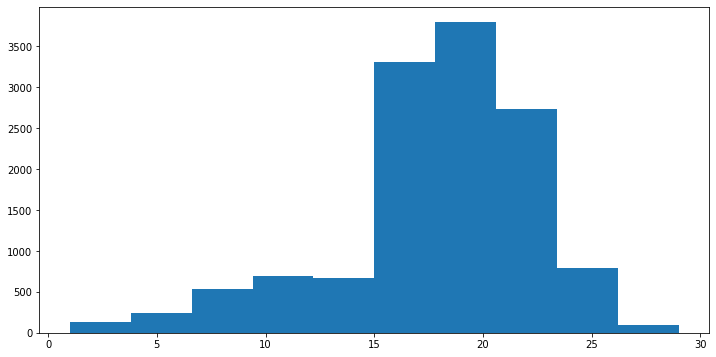

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
h1 = ax.hist(train_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 26

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((13000, 26), (3500, 26))

In [ ]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   2, 158,  26,  36, 781,  10, 726, 327,  59,   3, 168, 266],
      dtype=int32)

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
le.fit(train_sentiments)
list(le.classes_)

['Negative', 'Positive']

In [ ]:
y_train = le.transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
print(y_train)
print(len(y_train))
print(y_test)
print(len(y_test))

[1 1 1 ... 1 0 1]
13000
[1 1 0 ... 1 1 1]
3500


Prepare the Model

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
VOCAB_SIZE

12371

In [ ]:
EMBED_SIZE = 100
EPOCHS=15
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()

model.add(Embedding(VOCAB_SIZE, 
                    EMBED_SIZE, 
                    input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 100)           1237100   
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 128)           51328     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 64)            32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 32)             8224      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 32)             0

Model Training

In [ ]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
history = model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
 #         callbacks=[es], 
          verbose=1)

Epoch 1/15
92/92 [==============================] - 34s 21ms/step - loss: 0.2775 - accuracy: 0.8703 - val_loss: 0.2371 - val_accuracy: 0.9038
Epoch 2/15
92/92 [==============================] - 1s 16ms/step - loss: 0.0408 - accuracy: 0.9856 - val_loss: 0.2325 - val_accuracy: 0.9015
Epoch 3/15
92/92 [==============================] - 2s 17ms/step - loss: 0.0059 - accuracy: 0.9980 - val_loss: 0.3585 - val_accuracy: 0.9046
Epoch 4/15
92/92 [==============================] - 2s 17ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.4509 - val_accuracy: 0.9038
Epoch 5/15
92/92 [==============================] - 2s 16ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 0.4641 - val_accuracy: 0.8808
Epoch 6/15
92/92 [==============================] - 2s 17ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.4447 - val_accuracy: 0.9000
Epoch 7/15
92/92 [==============================] - 2s 16ms/step - loss: 6.8295e-04 - accuracy: 0.9997 - val_loss: 0.5341 - val_accuracy: 0.9108
Epoch 8/

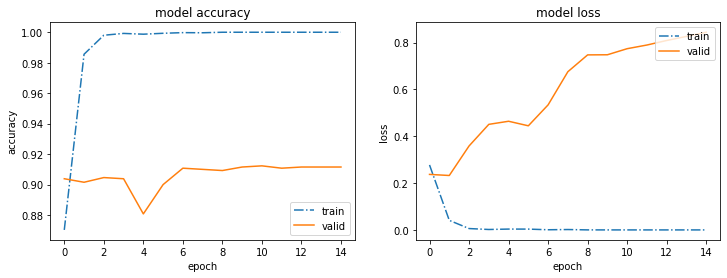

In [ ]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

Model Evaluation

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

110/110 [==============================] - 0s 3ms/step - loss: 0.9828 - accuracy: 0.8897
Accuracy: 88.97%


In [ ]:
predictions = model.predict(X_test)
predictions[200:210]

array([[9.99998927e-01],
       [1.00000000e+00],
       [9.93331015e-01],
       [4.14989557e-07],
       [8.23818922e-01],
       [1.11231575e-05],
       [6.56515766e-08],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00]], dtype=float32)

In [ ]:
predictions = ['Positive' if item == 1 else 'Negative' for item in predictions]
predictions[:10]

['Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative']

In [ ]:
test_sentiments

array(['Positive', 'Positive', 'Negative', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    Negative       0.39      0.97      0.55       614
    Positive       0.99      0.67      0.80      2886

    accuracy                           0.72      3500
   macro avg       0.69      0.82      0.68      3500
weighted avg       0.88      0.72      0.76      3500



,negative,positive
negative,594,20
positive,943,1943
